In [2]:
import model
import pandas as pd

In [22]:
scenario = model.CounterterrorismModel(N=400, height=3,width=4,prob_violence=0.0005,policy='NONE',reactive_lvl='none',discontent='mid')
for i in range(700):
    scenario.step()

/tmp/ipykernel_20194/1955557768.py:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


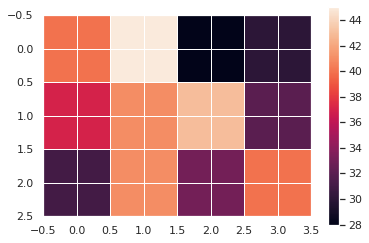

In [23]:
import numpy as np
import matplotlib.pyplot as plt

agent_counts = np.zeros((scenario.grid.width, scenario.grid.height))
for cell in scenario.grid.coord_iter():
    cell_content, x, y = cell
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count

plt.imshow(agent_counts, interpolation='nearest')
plt.colorbar()

<AxesSubplot:>

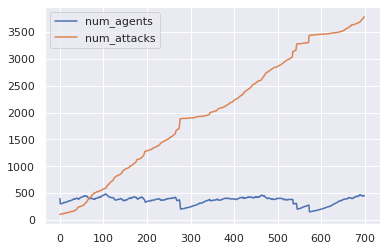

In [24]:
model_df = scenario.datacollector.get_model_vars_dataframe()
model_df.plot()

In [25]:
model_df

,num_agents,num_attacks
0,400,104
1,301,106
2,302,111
3,302,114
4,301,115
...,...,...
695,444,3744
696,450,3751
697,456,3758
698,455,3776


In [26]:
agents_df = scenario.datacollector.get_agent_vars_dataframe()
agents_df

status     loc
Step AgentID                       
1    1              neutral  (1, 1)
     2              neutral  (0, 2)
     3          sympathetic  (1, 1)
     4              neutral  (2, 1)
     5        anti-violence  (2, 1)
...                     ...     ...
700  4218     anti-violence  (1, 1)
     4219       sympathetic  (0, 0)
     4220           neutral  (1, 1)
     4221     anti-violence  (2, 3)
     4222       sympathetic  (1, 0)

[254388 rows x 2 columns]

In [27]:
agents_df = agents_df.reset_index()
agents_df['step_cat'] = agents_df.Step.astype('str')
agent_stati_gb = agents_df.groupby(by=['step_cat','status'])

In [28]:
agent_stati = agent_stati_gb['AgentID'].nunique().reset_index()
agent_stati = agent_stati.rename(columns={'AgentID':'num_agents'})
agent_stati['step'] = agent_stati.step_cat.astype('int')

palestinian_stati = agent_stati[agent_stati.status.isin(['anti-violence','combatant','neutral','sympathetic'])]
palestinian_stati

,step_cat,status,num_agents,step
1,1,anti-violence,114,1
2,1,combatant,106,1
3,1,neutral,94,1
4,1,sympathetic,86,1
6,10,anti-violence,160,10
...,...,...,...,...
3415,98,sympathetic,154,98
3417,99,anti-violence,112,99
3418,99,combatant,11,99
3419,99,neutral,178,99


<AxesSubplot:xlabel='step', ylabel='num_agents'>

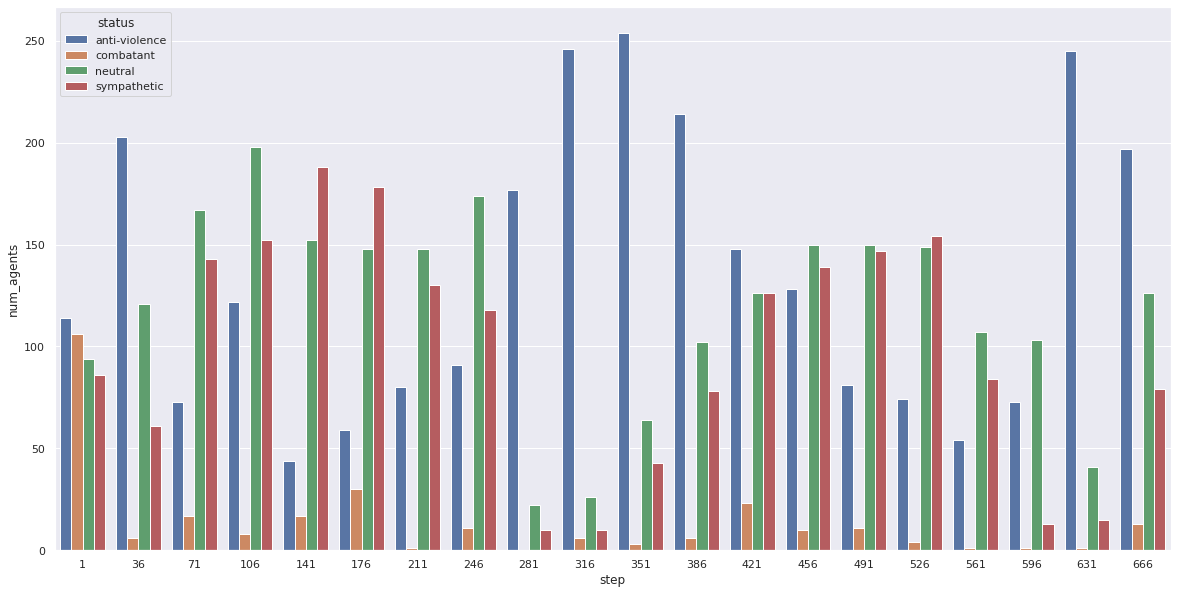

In [29]:
import seaborn as sns
import numpy as np
sns.set(style='darkgrid')
plt.figure(figsize=(20,10))

sns.barplot(x='step',y='num_agents',hue='status',data=palestinian_stati[palestinian_stati.step.isin(range(1,700,round(700*0.05)))])

neutral
neutral
neutral
anti-violence
sympathetic
anti-violence
anti-violence
anti-violence
sympathetic
anti-violence
anti-violence
sympathetic


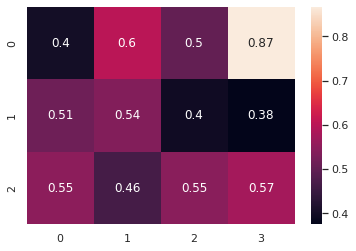

In [30]:
dominant_sentiments = np.zeros((scenario.grid.width, scenario.grid.height))
dominant_sentiments = dominant_sentiments.astype(str)
dominant_sentiments[dominant_sentiments=='0.0'] = 'none'
percent_dominant_sentiments = np.zeros((scenario.grid.width, scenario.grid.height))

for cell in scenario.grid.coord_iter():
    cell_content, x, y = cell
    status_dict = {'anti-violence':0,'NONE':0,'neutral':0,'sympathetic':0,\
        'combatant':0,'TARG-CONC':0,'TARG-REPR':0,'INDISC-CONC':0,'INDISC-REPR':0}
    for agent in cell_content:
        status_dict[agent.status] += 1

    dominant_sentiment =  max(status_dict, key = lambda x: status_dict[x])
    print(dominant_sentiment)
    if len(cell_content) > 0:
        perc_dominant_sentiment = max(status_dict.values())/len(cell_content)
    else:
        perc_dominant_sentiment = 0

    dominant_sentiments[x][y] = dominant_sentiment 
    percent_dominant_sentiments[x][y] = perc_dominant_sentiment  
     
ax = sns.heatmap(percent_dominant_sentiments, annot=True)
plt.show()

In [31]:
dominant_sentiments_df = pd.DataFrame(dominant_sentiments)
dominant_sentiments_df

,0,1,2,3
0,neutral,neutral,neutral,anti-violence
1,sympathetic,anti-violence,anti-violence,anti-violence
2,sympathetic,anti-violence,anti-violence,sympathetic


In [32]:
# code from stackoverflow
vals_to_int = {j:i for i, j in enumerate(pd.unique(dominant_sentiments.ravel()))}
vals_to_int

{'neutral': 0, 'anti-violence': 1, 'sympathetic': 2}

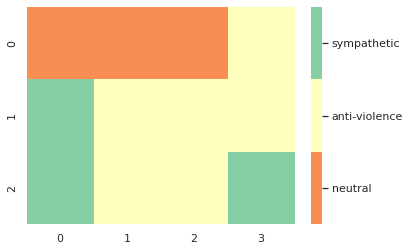

In [33]:
n = len(vals_to_int)
cmap = sns.color_palette('Spectral', n)
ax = sns.heatmap(dominant_sentiments_df.replace(vals_to_int),cmap=cmap)

colorbar = ax.collections[0].colorbar
r = colorbar.vmax - colorbar.vmin
colorbar.set_ticks([colorbar.vmin + r / n * (0.5 + i) for i in range(n)])
colorbar.set_ticklabels(list(vals_to_int.keys()))
plt.show()

In [34]:
govt_status = agent_stati[agent_stati.status.isin(['NONE','INDISC-REPR','INDISC-CONC','TARG-CONC','TARG-REPR'])]
govt_status.drop('num_agents', axis=1,inplace=True)
govt_status = govt_status.sort_values('step',ascending=True)
govt_status

/home/npodpx/venv/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,step_cat,status,step
0,1,INDISC-REPR,1
554,2,NONE,2
1095,3,NONE,3
1633,4,INDISC-CONC,4
2187,5,NONE,5
...,...,...,...
3234,696,NONE,696
3239,697,TARG-REPR,697
3244,698,INDISC-REPR,698
3249,699,NONE,699


In [35]:
govt_status_cum = govt_status.groupby(['status']).cumcount()
govt_status_cum = govt_status_cum.rename('cumulative_actions')
govt_status_cum = govt_status.join(govt_status_cum)
govt_status_cum.head(10)

,step_cat,status,step,cumulative_actions
0,1,INDISC-REPR,1,0
554,2,NONE,2,0
1095,3,NONE,3,1
1633,4,INDISC-CONC,4,0
2187,5,NONE,5,2
2721,6,INDISC-CONC,6,1
3254,7,NONE,7,3
3314,8,INDISC-CONC,8,2
3366,9,NONE,9,4
5,10,TARG-REPR,10,0


<AxesSubplot:xlabel='step', ylabel='cumulative_actions'>

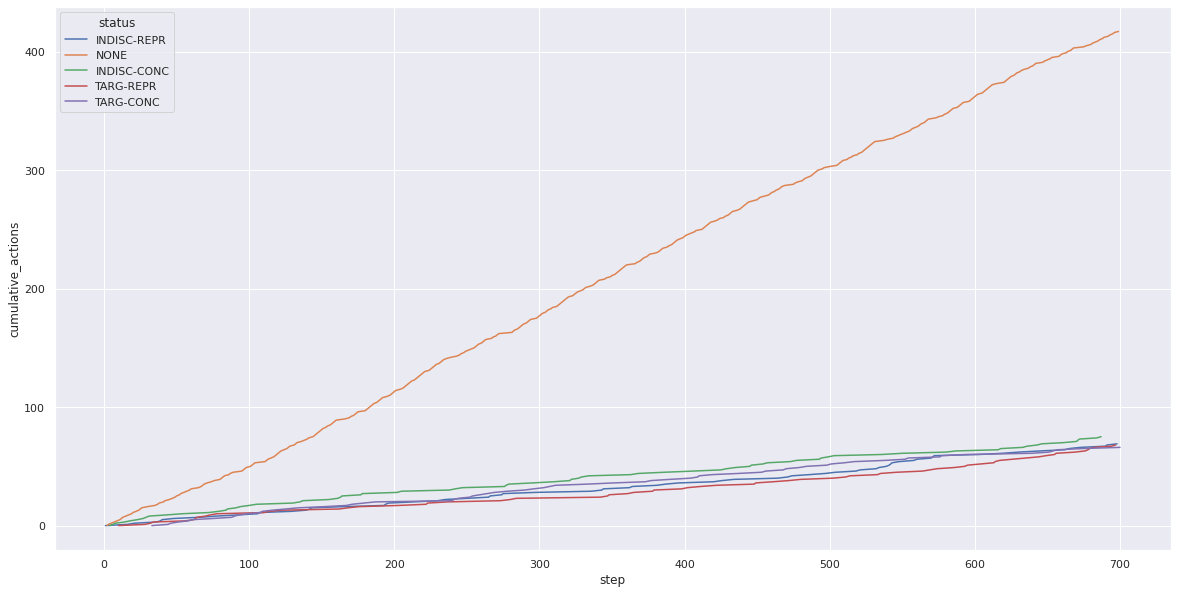

In [36]:
plt.figure(figsize=(20,10))

sns.lineplot(x='step',y='cumulative_actions',hue='status',data=govt_status_cum)

In [37]:
govt_status_cum = pd.get_dummies(govt_status['status']).cumsum()
govt_status_cum

,INDISC-CONC,INDISC-REPR,NONE,TARG-CONC,TARG-REPR
0,0,1,0,0,0
554,0,1,1,0,0
1095,0,1,2,0,0
1633,1,1,2,0,0
2187,1,1,3,0,0
...,...,...,...,...,...
3234,76,69,417,66,68
3239,76,69,417,66,69
3244,76,70,417,66,69
3249,76,70,418,66,69


In [38]:
scenario.datacollector.get_table_dataframe('Deaths')

,step,deaths
